# Modeling with Linear Regression
This notebook takes the dataframe created in the previous notebook on scraping and cleaning the data and runs it through various linear regression models to establish the best model to predict a given target

The target is the number of views received by a YouTube video

## Import Libraries
Import libraries used in the notebook

In [4]:
import sys

# EDA
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import \
    train_test_split, GridSearchCV, KFold, cross_val_score

from sklearn.linear_model import\
    LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.metrics import\
    mean_squared_error, r2_score, mean_absolute_error

from sklearn.pipeline import make_pipeline

import scipy.stats as stats
import scipy.special

import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Saving
import pickle

%matplotlib inline

# Python version checking
print("Python Version:", sys.version, '\n')

Python Version: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 13:42:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 



## Load and Inspect Dataset
Load the dataset made in the previous notebook. Look at the data within various columns before training any linear regression models

In [5]:
# Load dataset for youtube videos

with open('data/prev10_df.pickle', 'rb') as read_file:
    prev10_df = pickle.load(read_file)

df = prev10_df.reset_index().drop(labels='index', axis=1)

In [6]:
print('Columns:')
df.columns

Columns:


Index(['title', 'duration', 'channel', 'url', 'age', 'dislikes',
       'family_friendly', 'likes', 'paid', 'tags', 'unlisted', 'views',
       'prev_likes', 'prev_dislikes', 'prev_views', 'prev10_views',
       'prev20_views', 'prev15_views', 'title_length', 'title_compound_score'],
      dtype='object')

In [7]:
# Check for null items
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2763 entries, 0 to 2762
Data columns (total 20 columns):
title                   2763 non-null object
duration                2763 non-null int64
channel                 2763 non-null object
url                     2763 non-null object
age                     2763 non-null int64
dislikes                2763 non-null float64
family_friendly         2763 non-null float64
likes                   2763 non-null float64
paid                    2763 non-null float64
tags                    2763 non-null float64
unlisted                2763 non-null float64
views                   2763 non-null float64
prev_likes              2763 non-null float64
prev_dislikes           2763 non-null float64
prev_views              2763 non-null float64
prev10_views            2763 non-null float64
prev20_views            1336 non-null float64
prev15_views            2079 non-null float64
title_length            2763 non-null int64
title_compound_score    2763

In [8]:
# Drop columns with null values
df.drop(labels=['prev20_views', 'prev15_views'], axis=1, inplace=True)

In [9]:
df.describe()

,duration,age,dislikes,family_friendly,likes,paid,tags,unlisted,views,prev_likes,prev_dislikes,prev_views,prev10_views,title_length,title_compound_score
count,2763.000000,2763.00000,2763.000000,2763.000000,2763.000000,2763.0,2763.000000,2763.0,2.763000e+03,2763.000000,2763.000000,2.763000e+03,2.763000e+03,2763.000000,2763.000000
mean,763.671372,84.34781,411.740499,0.999638,16195.394499,0.0,20.675715,0.0,3.957596e+05,19439.790807,561.929786,5.455289e+05,6.766964e+05,8.967427,0.104835
std,405.572442,90.56436,1428.962497,0.019024,24637.304057,0.0,11.357043,0.0,5.460722e+05,36031.808531,2441.108821,1.366522e+06,1.723486e+06,3.396183,0.318219
min,6.000000,0.00000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,2.100000e+01,1.000000,0.000000,3.200000e+01,3.600000e+01,1.000000,-0.886800
25%,473.000000,20.00000,52.000000,1.000000,2719.000000,0.0,12.000000,0.0,6.800500e+04,2829.500000,54.500000,7.119700e+04,7.815800e+04,6.000000,0.000000
50%,723.000000,52.00000,125.000000,1.000000,6620.000000,0.0,20.000000,0.0,1.683310e+05,6875.000000,131.000000,1.805180e+05,1.965500e+05,9.000000,0.000000
75%,1023.000000,114.00000,345.000000,1.000000,18851.000000,0.0,29.000000,0.0,4.773005e+05,19917.000000,372.000000,5.254915e+05,5.941935e+05,11.000000,0.296750
max,1921.000000,444.00000,47576.000000,1.000000,332787.000000,0.0,60.000000,0.0,2.924506e+06,511402.000000,96544.000000,4.600310e+07,4.600310e+07,20.000000,0.943200


## Inspect Raw Data on a Pairplot
See if there are any relationships between variables that stand out as potential candidates for feature engineering

Text(0.5, 1, 'Pair Plot of Raw Data')

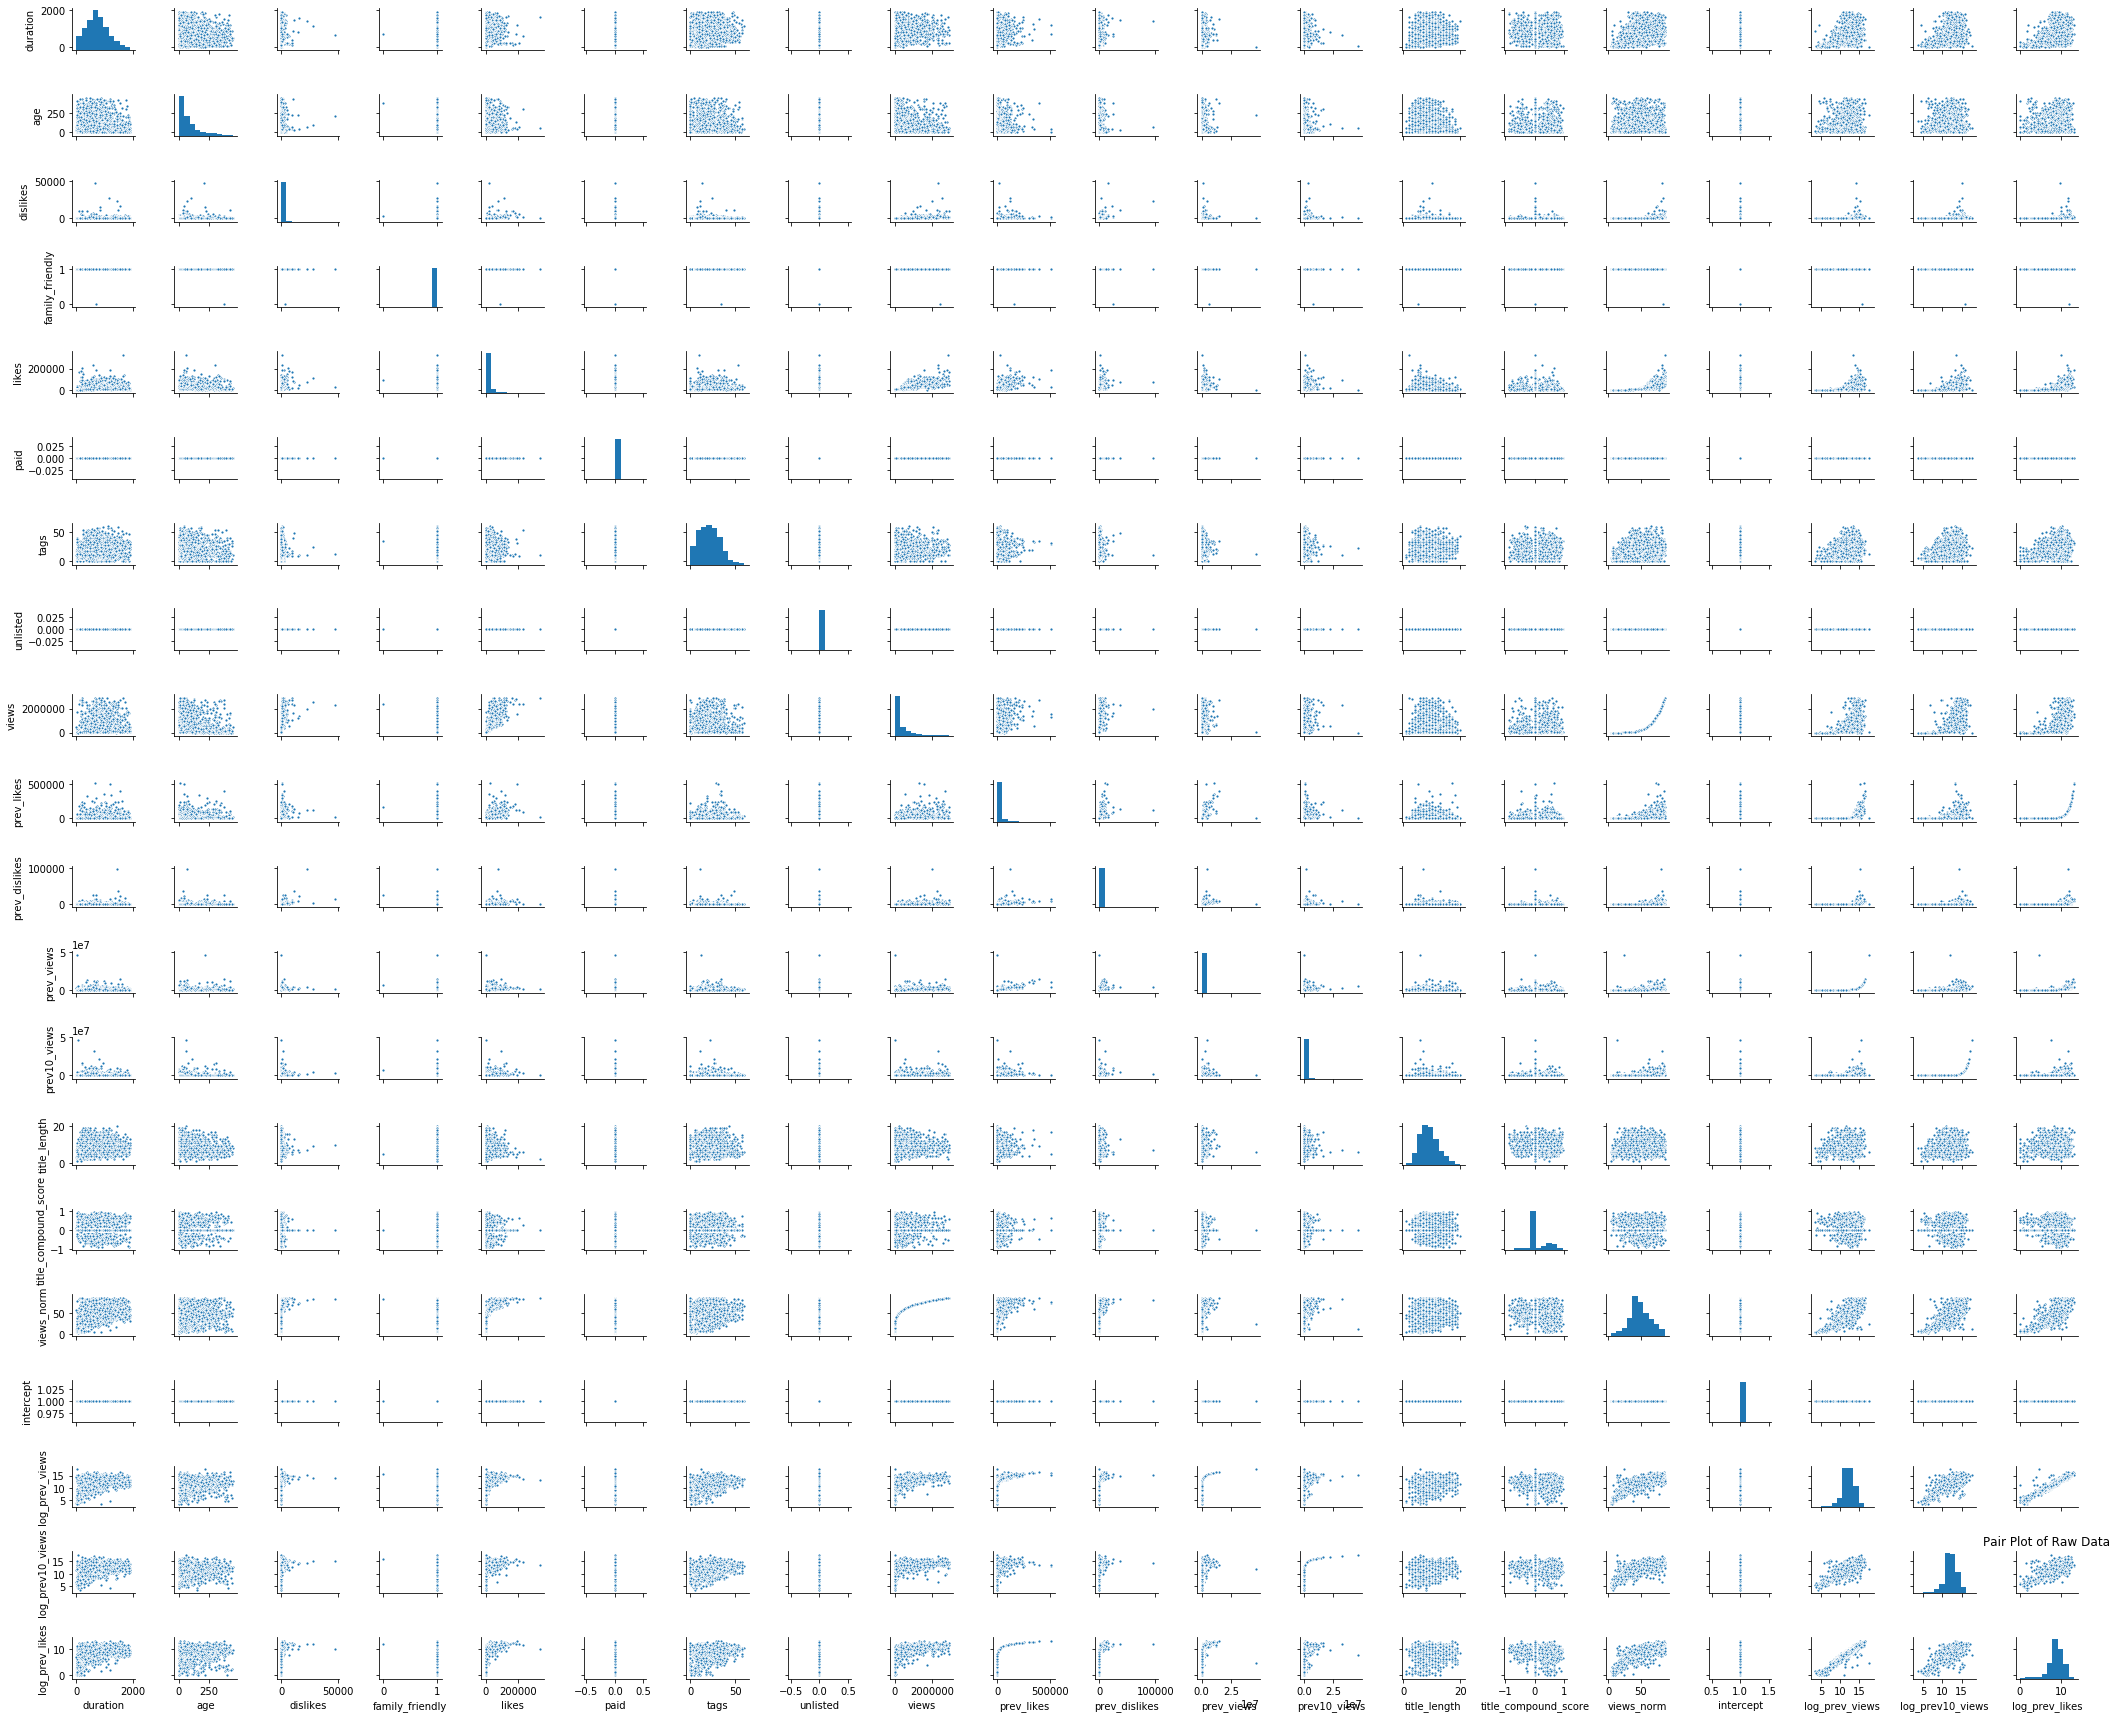

In [84]:
sns.pairplot(df, height=1.2, aspect=1.2, markers='.')
plt.title('Pair Plot of Raw Data')

It is hard to see what is going on, but it looks like there is some relationship between views and current/previous likes/dislikes/views
It also looks like a lot of the column values' distributions are heavily skewed

### Target Distribution
Inspecting the distribution of the target (View Count) shows that it is heavily skewed. Model performance is enhanced by normalizing this distribution. This transformation, done via a Box Cox transformation, is also necessary to satisfy the assumption of linear regression that the residuals are normally distributed about a mean of zero.

In [11]:
lamb = stats.boxcox_normmax(df.views, brack=(-4, 4))
print(
    "The lambda value that best normalizes the target distribution is: {:f}\n".
    format(lamb))
df['views_norm'] = stats.boxcox(df.views, lamb)

The lambda value that best normalizes the target distribution is: 0.193539



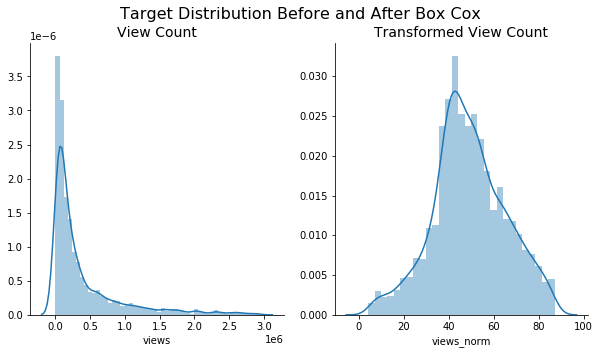

In [12]:
plt.subplots(2, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.distplot(df.views)
plt.title('View Count', size=14)
sns.despine()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.subplot(1, 2, 2)
sns.distplot(df.views_norm)
plt.title('Transformed View Count', size=14)
sns.despine()
plt.suptitle('Target Distribution Before and After Box Cox', size=16)
plt.savefig('img/target_pre_post_boxcox.png')

### Feature Distributions

In [13]:
# Add intercept column
df['intercept'] = 1

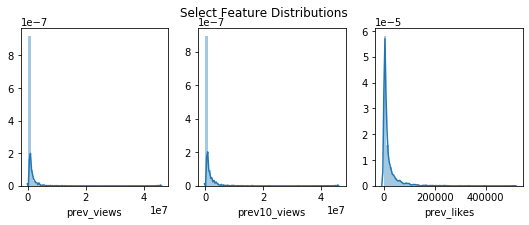

In [14]:
from matplotlib.ticker import FormatStrFormatter

fig, axs = plt.subplots(figsize=(9, 3))

plt.subplot(1, 3, 1)
sns.distplot(df.prev_views)
plt.subplot(1, 3, 2)
sns.distplot(df.prev10_views)
ax = plt.subplot(1, 3, 3)
sns.distplot(df.prev_likes)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.suptitle('Select Feature Distributions')
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('img/feat_eng_log_tr_before.png')

Similar to the target, previous views and likes are all heavily skewed right. Normalize them by using a simpler log transformation. This is not necessary, but it can improve the quality of the results

In [15]:
# Normalize prev_views count
df['log_prev_views'] = np.log(df.prev_views)

# Normalize prev10 views
df['log_prev10_views'] = np.log(df.prev10_views)

# Normalize previous likes
df['log_prev_likes'] = np.log(df.prev_likes)

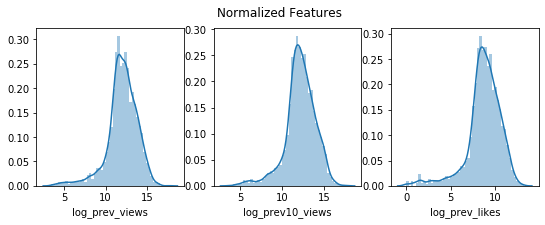

In [16]:
# Plot the new distributions

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
sns.distplot(df.log_prev_views)
plt.subplot(1, 3, 2)
sns.distplot(df.log_prev10_views)
plt.subplot(1, 3, 3)
sns.distplot(df.log_prev_likes)
plt.suptitle('Normalized Features')
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('img/feat_eng_log_tr_after.png')

In [17]:
# Save df with normalized feature/target columns added

with open('data/prev10df_modeling.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

## Set Up Features and Target for Modeling

In [18]:
df.columns

Index(['title', 'duration', 'channel', 'url', 'age', 'dislikes',
       'family_friendly', 'likes', 'paid', 'tags', 'unlisted', 'views',
       'prev_likes', 'prev_dislikes', 'prev_views', 'prev10_views',
       'title_length', 'title_compound_score', 'views_norm', 'intercept',
       'log_prev_views', 'log_prev10_views', 'log_prev_likes'],
      dtype='object')

Initial EDA and test runs of various linear regression models revealed that previous views and previous likes were highly correlated features. Previous views was maintained as a feature to be considered in the model.

In [19]:
# Set up target and features

y = df['views_norm']  # Target vector (series)

# establish a base case for performance on the skewed target data
y_no_transform = df['views']

# Feature names
x_cols = [
    'intercept', 'duration', 'age', 'log_prev_views', 'log_prev10_views',
    'tags', 'family_friendly', 'title_length', 'title_compound_score'
]

# Feature matrix (dataframe)
X = df[x_cols]

Look at the correlation matrix to see relationships between target and the features. 
This suggests there may be a collinearity between the length of a video and the amount of views the same user's previous videos received

In [20]:
# Correlation Matrix of target and features
df[x_cols + ['views_norm']].corr()

,intercept,duration,age,log_prev_views,log_prev10_views,tags,family_friendly,title_length,title_compound_score,views_norm
intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,NaN,1.000000,-0.092933,0.299842,0.288123,0.115779,0.003645,0.049877,-0.003837,0.320727
age,NaN,-0.092933,1.000000,-0.044619,-0.092978,-0.063539,-0.061288,-0.186172,-0.033013,-0.005356
log_prev_views,NaN,0.299842,-0.044619,1.000000,0.777305,0.114554,-0.038321,0.060999,-0.064131,0.783377
log_prev10_views,NaN,0.288123,-0.092978,0.777305,1.000000,0.108875,-0.038143,0.062568,-0.064895,0.751612
tags,NaN,0.115779,-0.063539,0.114554,0.108875,1.000000,-0.022328,0.070428,0.003821,0.079041
family_friendly,NaN,0.003645,-0.061288,-0.038321,-0.038143,-0.022328,1.000000,0.022232,0.006270,-0.040778
title_length,NaN,0.049877,-0.186172,0.060999,0.062568,0.070428,0.022232,1.000000,0.056990,0.051357
title_compound_score,NaN,-0.003837,-0.033013,-0.064131,-0.064895,0.003821,0.006270,0.056990,1.000000,-0.087274
views_norm,NaN,0.320727,-0.005356,0.783377,0.751612,0.079041,-0.040778,0.051357,-0.087274,1.000000


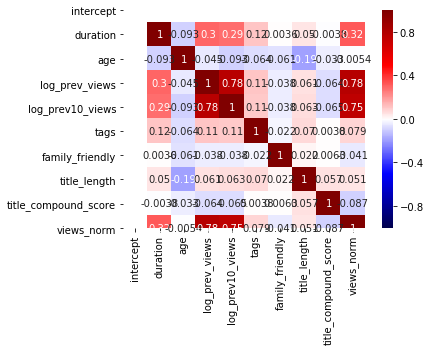

In [923]:
sns.heatmap(df[x_cols + ['views_norm']].corr(),
            cmap="seismic",
            annot=True,
            vmin=-1,
            vmax=1,
            square=True)

We can expect that previous views, 10th previous views, duration, and title_compound_score will have the strongest effects on the view count based on the correlation matrix

Finally, look at the pairplot with all of the transformed variables before starting to create models

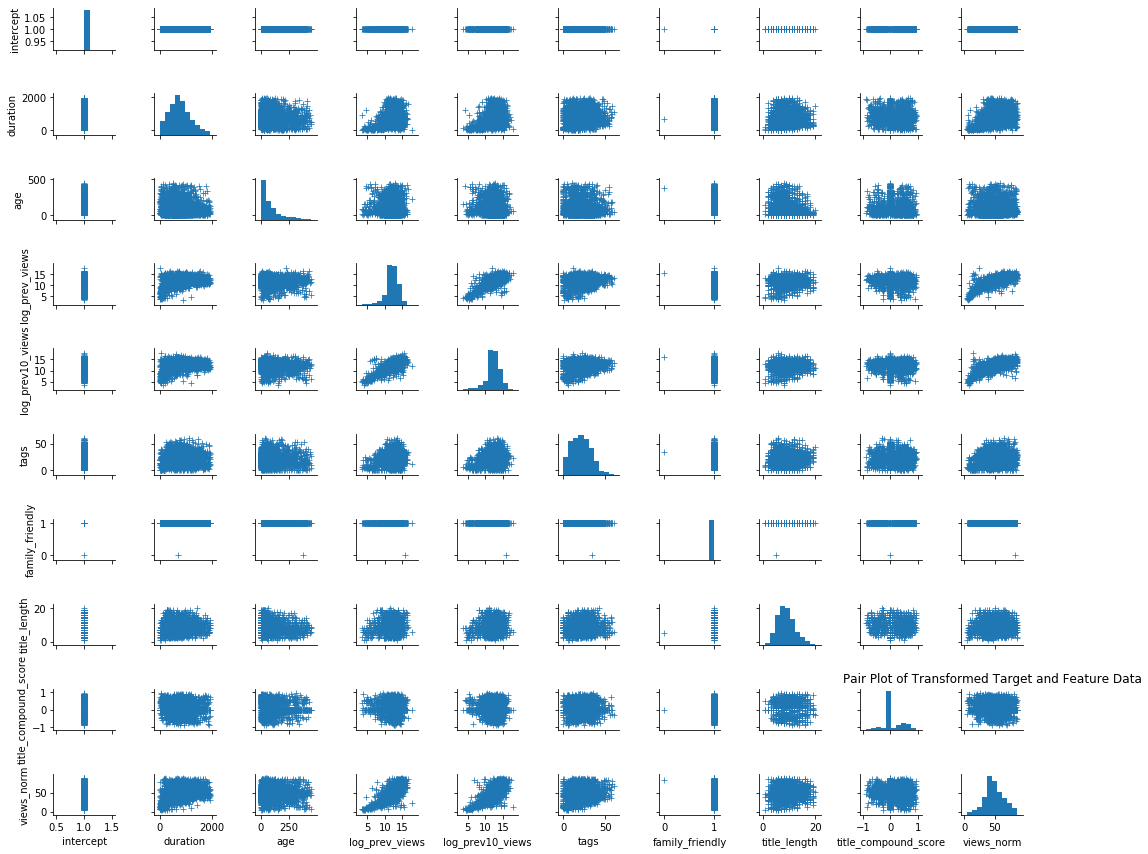

In [924]:
sns.pairplot(df[x_cols + ['views_norm']], height=1.2, aspect=1.2, markers='+')
plt.title('Pair Plot of Transformed Target and Feature Data')

A lot of the features are more normally distributed now, and correlations can be seen between views and previous views, 10th previous views, and duration

### Split data into training and testing sets
Train / test split with 80% to train and validate the model and 20% to test the final model

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=77)

# Train test split for untransformed target data
X_train_nt, X_test_nt, y_train_nt, y_test_nt = train_test_split(
    X, y_no_transform, test_size=.2, random_state=77)

### Standardize the feature data

All features are standardized using a standard scaler, which forces the column to have a mean = 0 and a standard deviation = 1, resulting in a z-score in place of each value. While both the training and testing data are scaled, the actual scaler is fit only on the training data to avoid bleeding any information from the testing data.

In [23]:
# Scale the data

scaler = StandardScaler()

# Fit the scaler using the training data and scale it
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                              columns=x_cols)

# Reset intercept column to a nonzero value
X_train_scaled['intercept'] = 1

# Scale the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values), columns=x_cols)
X_test_scaled['intercept'] = 1

## Modeling
### Functions
Set up functions to be used in evaluating all functions

In [24]:
def adj_r2(r2, feat_data):
    '''
    Calculates the adjusted R-squared value (float)
    for a linear regression model
    ---
    Inputs:
    -r2(float)
    -feature dataset (np.array or dataframe)
    '''
    num_features = feat_data.shape[1]
    num_data = feat_data.shape[0]
    temp = (1 - r2) * (num_data - 1)
    temp = temp / (num_data - num_features - 1)
    temp = 1 - temp
    return temp

In [25]:
def calc_mae_rmse(df):
    """
    Calculates and prints the mean absolute error and
    root mean squared error for a model given its
    actual target data and predicted target data
    ---
    input: dataframe with 'y_test' as first column,
        'y_pred' as second column
    output: mae(float), rmse(float)
    """

    print('Mean Absolute Error')
    mae = mean_absolute_error(df['y_test'], df['y_pred'])
    print(mae)
    print('Root Mean Squared Error')
    rmse = np.sqrt(mean_squared_error(df['y_test'], df['y_pred']))
    print(rmse)
    return mae, rmse

In [26]:
def undo_boxcox(y_test, y_pred, lamb=lamb):
    '''
    This function should be used when interpreting the
    results of a linear regression model if the target
    variable has been transformed using a Box Cox Transformation.
    Returns a dataframe with actual and predicted test
    data after undoing the Box Cox transformation
    ---
    input: y_test (Series), y_pred (numpy array)
    output: dataframe
    '''
    y_pred_invboxcox = scipy.special.inv_boxcox(y_pred, lamb)
    y_test_invboxcox = scipy.special.inv_boxcox(y_test, lamb)
    test_and_pred = pd.concat(
        [y_test_invboxcox.reset_index(),
         pd.Series(y_pred_invboxcox)], axis=1).drop(labels='index',
                                                    axis=1).dropna()
    test_and_pred.rename({
        'views_norm': 'y_test',
        0: 'y_pred'
    },
                         axis=1,
                         inplace=True)
    return test_and_pred

### Variables
Define variables used in all OLS models (when using SciKit learn package)

In [27]:
# Define splits for cross validating each model
kf = KFold(n_splits=10, shuffle=True, random_state=40)

### Ordinary Least Squares with statsmodel - inspect summary stats

First try an Ordinary Least Squares linear regression model

Use the statsmodel package to get a full list of summary statistics for the mdoel

In [28]:
# Build a linreg model with statsmodel
lsm = sm.OLS(list(y_train), X_train_scaled)

lm_fit = lsm.fit()

print(lm_fit.summary().as_csv(), file=open("simpleOLS_summary.txt", "a"))
lm_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     584.4
Date:                Thu, 10 Oct 2019   Prob (F-statistic):               0.00
Time:                        17:28:20   Log-Likelihood:                -8045.2
No. Observations:                2210   AIC:                         1.611e+04
Df Residuals:                    2201   BIC:                         1.616e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept               49.3531      0.197    251.110      0.000      48.968      49.739
duration                 1.1383      0.208      5.470      0.000       0.730       1.546
age                      0.8994      0.202      4.456      0.000       0.504       1.295
log_prev_views           8.0288      0.313     25.655      0.000       7.415       8.642
log_prev10_views         5.8254      0.312     18.680      0.000       5.214       6.437
tags                    -0.4586      0.199     -2.304      0.021      -0.849      -0.068
family_friendly         -0.0958      0.197     -0.485      0.627      -0.483       0.291
title_length             0.2437      0.201      1.213      0.225      -0.150       0.638
title_compound_score    -0.4798      0.198     -2.429      0.015      -0.867      -0.092
==============================================================================
Omnibus:                      303.051   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1067.922
Skew:                           0.660   Prob(JB):                    1.27e-232
Kurtosis:                       6.139   Cond. No.                         2.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Feature Importance**: Low P-values on the features duration, age, previous views, 10th previous views, and tags imply that those features are important to the model. Modeling with regularization will help to confirm this.

#### Multicollinearity

Despite the low condition number, it is still a good idea to run an additional check for multicollinearity between features. Calculate the Variance Inflation Factor to identify which features might be collinear 

In [29]:
vif = pd.DataFrame()
vif["VIF Factor"] = [
    variance_inflation_factor(X_train_scaled.values, i)
    for i in range(X_train_scaled.shape[1])
]
vif["features"] = X.columns

In [30]:
print(vif, file=open("vif.txt", "a"))
vif

,VIF Factor,features
0,1.000000,intercept
1,1.121047,duration
2,1.054419,age
3,2.535472,log_prev_views
4,2.517600,log_prev10_views
5,1.025997,tags
6,1.008333,family_friendly
7,1.045073,title_length
8,1.009850,title_compound_score


All VIF factors are low, which suggests that none of the features are collinear

## Linear Regression with SciKit Learn

### Fitting an OLS model to untransformed target data - establish a base case
Run a Linear Regression on untransformed target data to establish a base case for performance of the model before transforming the target so the model can adhere to the assumptions of linear regression
Subsequent modeling done with a transformed target variable should have better results

In [31]:
lm_nt = LinearRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=40)
print(
    'Linear Regression model with skewed (untransformed) target data R^2: {:f}'
    .format(
        np.mean(
            cross_val_score(lm_nt, X_train_nt, y_train_nt, cv=kf,
                            scoring='r2'))))

lm_nt.fit(X_train_nt, y_train_nt)

Linear Regression model with skewed (untransformed) target data R^2: 0.340547


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
# Predict target values using test feature data for the base vase OLS model
y_pred_lm_nt = lm_nt.predict(X_test_nt)

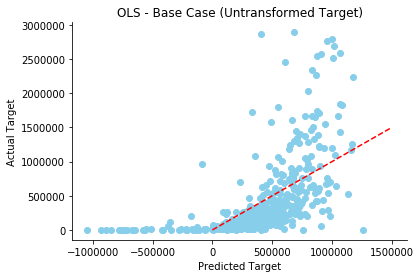

In [33]:
plt.scatter(y_pred_lm_nt, y_test_nt, color='skyblue')
sns.despine()
plt.xlabel('Predicted Target')
plt.ylabel('Actual Target')
plt.title('OLS - Base Case (Untransformed Target)')
plt.plot([0, 1500000], [0, 1500000], '--', color='red')

This plot shows that the model is not a good predictor of the target variable. The dashed line represents a perfect correlation between predicted and actual values

Looking at a plot of the residuals vs the predicted values, several of the assumptions of linear regression are not met. Errors are not normally distributed about a zero mean

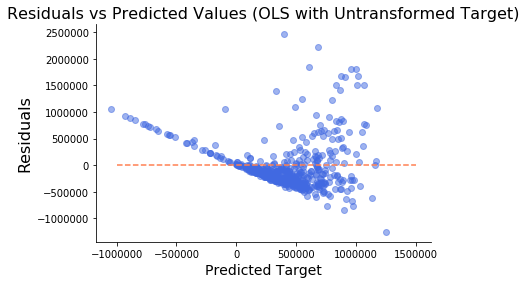

In [34]:
# Plot residuals vs predicted target values
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_lm_nt,
            y_test_nt - y_pred_lm_nt,
            alpha=0.5,
            color='royalblue')
plt.xlabel('Predicted Target', size=14)
sns.despine()
plt.ylabel('Residuals', size=16)
plt.plot([-1000000, 1500000], [0, 0], '--', color='coral')
plt.title('Residuals vs Predicted Values (OLS with Untransformed Target)',
          size=16)
plt.savefig('img/resid_pred_untransform.png')

In [35]:
# Set up DataFrame with actual and predicted test values
# to evaluate performance of the base case model
test_and_pred_base = pd.concat(
    [y_test_nt.reset_index(), pd.Series(y_pred_lm_nt)],
    axis=1).drop(labels='index', axis=1).dropna()
test_and_pred_base.rename({
    'views': 'y_test',
    0: 'y_pred'
},
                          axis=1,
                          inplace=True)

In [36]:
# Calculate model performance
# Base case (OLS, untransformed target)

mae_base, rmse_base = calc_mae_rmse(test_and_pred_base)

Mean Absolute Error
295309.85762388137
Root Mean Squared Error
425992.320475145


The values calculated for R-squared, mean absolute error, and root mean squared error should all improve once the target variable is transformed to be more normally distributed before training the model

### OLS with Transformed Target in SciKit Learn
Repeat the model done above using the SciKit tools, which are also used for the other models considered in this notebook

The scoring metric used to compare models is R^2, which measures the strength of the relationship between the model and the target variable

Use cross-validation with 10 splits to get a more accurate R^2 score that will be less influenced by random chance in the validation/test split process

In [37]:
lm = LinearRegression()  # Instantiate model
lm.fit(X_train_scaled, y_train)
# Fit model to the training data

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
print('OLS Linear Regression Model Coefficients')
list(zip(X.columns, lm.coef_))

OLS Linear Regression Model Coefficients


[('intercept', 0.0),
 ('duration', 1.1383390522586598),
 ('age', 0.8993903893535268),
 ('log_prev_views', 8.028767052958358),
 ('log_prev10_views', 5.825390682580938),
 ('tags', -0.45863800970587043),
 ('family_friendly', -0.09581231001866786),
 ('title_length', 0.24369708197640877),
 ('title_compound_score', -0.47979299949236814)]

Note that these coefficients are almost equal to the ones calculated using the statsmodel package.

Interpreting the coefficients

In [113]:
log_prev_views_coef = lm.coef_[3]
log_prev_views_std = np.std(X_train['log_prev_views'])
print(
    "For every additional additional view on a Channel's latest video,\n\
there will be an increase in views on the next video of {:f}"
    .format(
        scipy.special.boxcox(np.exp(log_prev_views_coef / log_prev_views_std),
                             lamb)))

For every additional additional view on a Channel's latest video,
there will be an increase in views on the next video of 6.855673


In [115]:
log_prev10_views_coef = lm.coef_[4]
log_prev10_views_std = np.std(X_train['log_prev10_views'])
print(
    "For every additional additional view on a Channel's tenth oldest video,\n\
there will be an increase in views on the next video of {:f}"
    .format(
        scipy.special.boxcox(
            np.exp(log_prev10_views_coef / log_prev10_views_std), lamb)))

For every additional additional view on a Channel's tenth oldest video,
there will be an increase in views on the next video of 4.412991


In [120]:
duration_coef = lm.coef_[1]
duration_std = np.std(X_train['duration'])
print('For every additional second, there is an increase in views of {:f}'.
      format(scipy.special.inv_boxcox(duration_coef / duration_std, lamb)))

For every additional second, there is an increase in views of 1.002817


In [121]:
age_coef = lm.coef_[2]
age_std = np.std(X_train['age'])
print('For every additional day since publishing, there is an increase in views of {:f}'.
      format(scipy.special.inv_boxcox(age_coef / age_std, lamb)))

For every additional day since publishing, there is an increase in views of 1.009930


In [39]:
# Calculate R-squared using cross-validation
r2_lm = np.mean(
    cross_val_score(lm, X_train_scaled, y_train, cv=kf, scoring='r2'))
print('OLS Linear Regression model R^2 on in-sample data: {:f}'.format(r2_lm))

OLS Linear Regression model R^2 on in-sample data: 0.672491


In [40]:
# Get vector of predicted target values by feeding the
# test feature data through the trained model
y_pred_lm = lm.predict(X_test_scaled)

In [41]:
print('OLS model R^2 on out-of-sample data: {:f}'.format(
    lm.score(X_test_scaled, y_test)))

OLS model R^2 on out-of-sample data: 0.646405


In [42]:
# Undo the box cox transformation on the actual and
# predicted data to interpret the model performance
ols_test_pred = undo_boxcox(y_test, y_pred_lm)
# Calculate Error Metrics
mae_lm, rmse_lm = calc_mae_rmse(ols_test_pred)

Mean Absolute Error
190022.26323624898
Root Mean Squared Error
379676.6287119418


In [43]:
resid_lm = y_test - y_pred_lm  # Calculate residuals

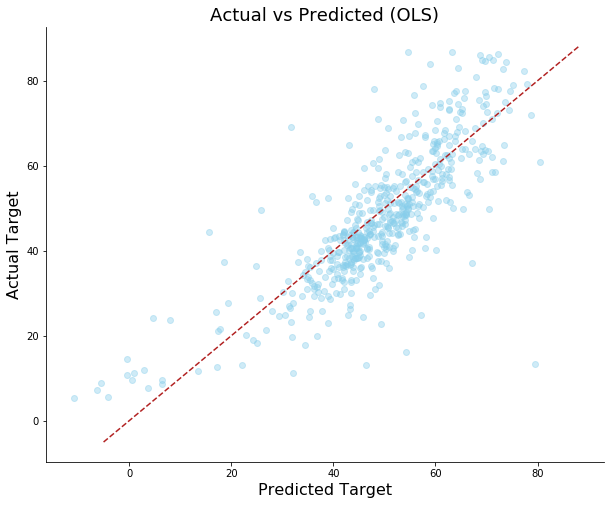

In [44]:
# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.plot([-5, 88], [-5, 88], '--', c='firebrick')
plt.scatter(y_pred_lm, y_test, color='skyblue', alpha=0.4)
plt.xlabel('Predicted Target Values')
plt.ylabel('Actual Target Values')
sns.despine()
plt.ylabel('Actual Target', size=16)
plt.xlabel('Predicted Target', size=16)
plt.title('Actual vs Predicted (OLS)', size=18)
plt.savefig('img/lm_ycompare_bc.png')

The red line represents a perfect model (y_intercept at 0, slope of 1, y_predicted = y_actual). This is a good visual representation of how closely the model predicts the target based on the test features

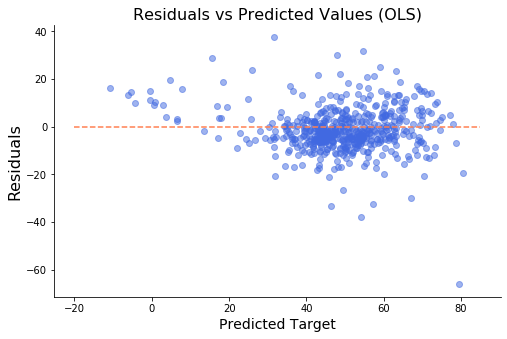

In [663]:
# Plot residuals vs predicted target values
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_lm, resid_lm, alpha=0.5, color='royalblue')
plt.xlabel('Predicted Target', size=14)
sns.despine()
plt.ylabel('Residuals', size=16)
plt.plot([-20, 85], [0, 0], '--', color='coral')
plt.title('Residuals vs Predicted Values (OLS)', size=16)
plt.savefig('img/resid_vs_pred.png')

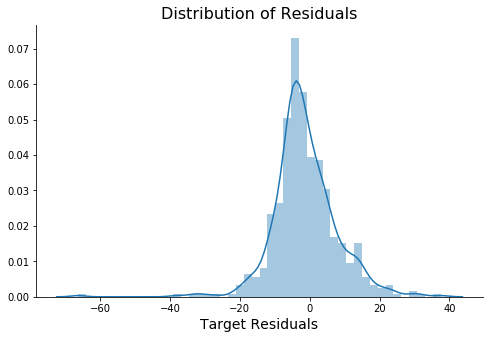

In [665]:
# Plot distribution of residuals
plt.figure(figsize=(8, 5))
sns.distplot(resid_lm)
plt.xlabel('Target Residuals', size=14)
sns.despine()
plt.title('Distribution of Residuals', size=16)
plt.savefig('img/resid_dist.png')

Make a bar plot to illustrate feature importance

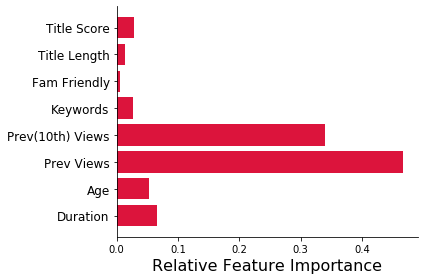

In [117]:
fig, ax = plt.subplots()
plt.barh(np.arange(len(lm.coef_) - 1),
         np.abs(lm.coef_[1:]) / sum(np.abs(lm.coef_[1:])),
         color='crimson')
ax.set_yticks(np.arange(len(lm.coef_) - 1))
plt.xlabel('Relative Feature Importance', size=16)
sns.despine()
ax.set_yticklabels([
    'Duration',
    'Age',
    'Prev Views',
    'Prev(10th) Views',
    'Keywords',
    'Fam Friendly',
    'Title Length',
    'Title Score',

],
                   size=12)
plt.tight_layout()
plt.savefig('img/feat_importance.png',transparent=True);

In [75]:
X.columns

Index(['intercept', 'duration', 'age', 'log_prev_views', 'log_prev10_views',
       'tags', 'family_friendly', 'title_length', 'title_compound_score'],
      dtype='object')

Look at a side by side comparison of the performance of the base case scenario and that of the transformed target

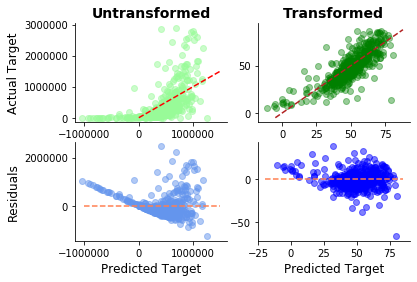

In [899]:
fig_compare = plt.subplots(2, 2)

plt.subplot(2, 2, 1)
plt.scatter(y_pred_lm_nt, y_test_nt, color='palegreen', alpha=0.5)
sns.despine()
plt.ylabel('Actual Target', size=12)
plt.title('Untransformed', size=14, fontweight='bold')
plt.plot([0, 1500000], [0, 1500000], '--', color='red')

plt.subplot(2, 2, 2)
plt.plot([-5, 88], [-5, 88], '--', c='firebrick')
plt.scatter(y_pred_lm, y_test, color='green', alpha=0.4)
sns.despine()
plt.title('Transformed', size=14, fontweight='bold')

plt.subplot(2, 2, 3)
plt.scatter(y_pred_lm_nt,
            y_test_nt - y_pred_lm_nt,
            alpha=0.5,
            color='cornflowerblue')
plt.xlabel('Predicted Target', size=12)
sns.despine()
plt.ylabel('Residuals', size=12)
plt.plot([-1000000, 1500000], [0, 0], '--', color='coral')

plt.subplot(2, 2, 4)
plt.scatter(y_pred_lm, resid_lm, alpha=0.5, color='blue')
plt.xlabel('Predicted Target', size=12)
sns.despine()
plt.plot([-20, 85], [0, 0], '--', color='coral')

plt.savefig('img/transform_compare.png')

## Linear Regression with Polynomial Features

Polynomial Regression is an effective tool in feature engineering. It can identify features that should be transformed to a higher degree or potentially important feature interactions

In [859]:
degree = 2

poly = PolynomialFeatures(degree=degree)

# Fit polynomial features and transform on training data
X_train_poly = poly.fit_transform(X_train.values)

# Transform test data
X_test_poly = poly.transform(X_test.values)

# Instantiate polynomial features with linear regression
# and fit to training data
lm_poly = LinearRegression()
lm_poly.fit(X_train_poly, y_train)

In [860]:
print('Polynomial Features Model Coefficients')
lm_poly.coef_

Polynomial Features Model Coefficients


array([-9.01540389e-11,  6.97672043e-11, -7.79628778e-03,  1.26398804e-03,
       -3.34322589e-01, -7.16334606e-01,  1.25486970e-01,  2.80328290e-05,
        2.41825751e-01, -1.41933465e+00,  1.95681665e-12, -7.79628776e-03,
        1.26398804e-03, -3.34322589e-01, -7.16334606e-01,  1.25486970e-01,
        2.80328287e-05,  2.41825751e-01, -1.41933465e+00, -3.96345883e-06,
        4.40875229e-07,  9.68989877e-04,  2.28109657e-04,  9.30739761e-05,
        1.14342328e-02, -1.89632553e-04,  3.10474304e-03, -6.07821328e-05,
        2.86017423e-03, -2.17079043e-03,  2.51770397e-04,  1.18043317e-02,
        5.50405270e-05,  1.66323578e-03,  3.76974008e-02,  3.66751389e-01,
       -1.47689926e-02, -3.33882382e-01, -1.59683773e-02,  5.43435135e-01,
        9.01734031e-02, -3.11473720e-02, -7.15891519e-01, -4.06650124e-02,
       -2.57376013e-01,  4.83606686e-04,  1.26440086e-01,  4.61548169e-03,
       -1.90124143e-02,  2.80328288e-05,  2.41965916e-01, -1.41933465e+00,
        9.13627470e-03, -

In [861]:
# Calculate R^2 and Adjusted R^2 for the model with polynomial features
r2_poly = np.mean(
    cross_val_score(lm_poly, X_train_poly, y_train, cv=kf, scoring='r2'))
print('Degree 2 polynomial R^2 on in-sample data: {:f}'.format(r2_poly))

adj_r2_poly = adj_r2(r2_poly, X_train_poly)
print('Degree 2 polynomial adjusted_R^2 on in-sample data: {:f}'.format(
    adj_r2_poly))

Degree 2 polynomial R^2 on in-sample data: 0.693514
Degree 2 polynomial adjusted_R^2 on in-sample data: 0.685688


In [862]:
# Undo the box cox transformation on the actual and
# predicted data to interpret the model performance
poly_test_pred = undo_boxcox(y_test, y_pred_poly)
# Calculate Error Metrics
mae_lm, rmse_lm = calc_mae_rmse(poly_test_pred)

Mean Absolute Error
192563.06150593195
Root Mean Squared Error
401409.297044214


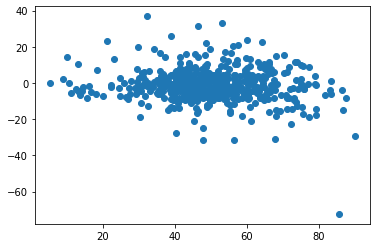

In [700]:
y_pred_poly = lm_poly.predict(X_test_poly)
plt.scatter(y_pred_poly, y_test - y_pred_poly)

In [668]:
# Plot residuals
# resid_poly = y_test - y_pred_poly
# sns.distplot(resid_poly)
# plt.title('Residuals (Linear Regression with Polynomial Features)');

## Regularization

Cross validation is used to determine the best value of alpha which minimizes the cost function in each regularization model. Set up an array of candidate values for alpha

In [826]:
# Set up alpha candidate values for regularization models
# Alpha is the hyperparameter that controls how
# heavily features are penalized for high coefficients
param_grid = {'alpha': 10**np.linspace(-3, 3, 600)}

### LASSO

Use LASSO to see if any features should be eliminated to further simplify the model by "punishing" features for having high coefficients and helps avoid over-fitting.

In [827]:
# Instantiate the LASSO model
my_grid_search = GridSearchCV(Lasso(),
                              param_grid,
                              cv=kf,
                              n_jobs=-1,
                              scoring='r2')

In [828]:
# Fit the model to the scaled training data
my_grid_search.fit(X_train_scaled, y_train)
lasso_gridcv_model = my_grid_search.best_estimator_

In [831]:
# Use model to predict target values on the testing data
y_pred_lasso = lasso_gridcv_model.predict(X_test_scaled)

In [829]:
print('LASSO Model Alpha = {:f}'.format(lasso_gridcv_model.alpha))

LASSO Model Alpha = 0.002516


In [565]:
print('LASSO Model Coefficients')
list(zip(X.columns, lasso_gridcv_model.coef_))

LASSO Model Coefficients


[('intercept', 0.0),
 ('duration', 1.135487825408342),
 ('age', 0.8957883838392142),
 ('log_prev_views', 8.028483195525355),
 ('log_prev10_views', 5.823287193867418),
 ('tags', -0.45496560689183946),
 ('family_friendly', -0.0930248269031902),
 ('title_length', 0.2398607690568594),
 ('title_compound_score', -0.476838760496731)]

In [830]:
# Evaluate performance metrics
print('LASSO model R^2 on in-sample data: {:f}'.format(
    lasso_gridcv_model.score(X_train_scaled, y_train)))
print('LASSO model R^2 on out-of-sample data: {:f}'.format(
    lasso_gridcv_model.score(X_test_scaled, y_test)))

LASSO model R^2 on in-sample data: 0.679924
LASSO model R^2 on out-of-sample data: 0.646431


After training the LASSO model, all of the feature coefficients are nonzero. 

In [591]:
# Undo box cox transformation
lasso_test_pred = undo_boxcox(y_test, y_pred_lasso)

# Calculate MAE and RMSE
mae_lasso, rmse_lasso = calc_mae_rmse(lasso_test_pred)

Mean Absolute Error
190010.93759272437
Root Mean Squared Error
379686.280584478


In [833]:
resid_lasso = y_test - y_pred_lasso  # Calculate residuals for LASSO model

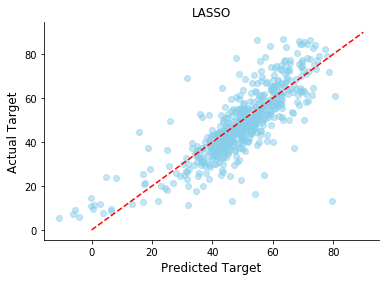

In [834]:
# Plot the predicted values vs the actual target values
plt.scatter(y_pred_lasso, y_test, color='skyblue', alpha=0.5)
plt.plot([0, 90], [0, 90], '--', c='red')
sns.despine()
plt.ylabel('Actual Target', size=12)
plt.xlabel('Predicted Target', size=12)
plt.title('LASSO')
plt.savefig('img/lasso_ycompare_bc.png')

In [669]:
# Plot residuals
# sns.distplot(resid_lasso)
# plt.title('Residuals (LASSO)');

### LARS Path for Lasso

In [569]:
from sklearn.linear_model import lars_path

alphas, _, coefs = lars_path(X_train_scaled, y_train.values, method='lasso')

AttributeError: 'DataFrame' object has no attribute 'dtype'

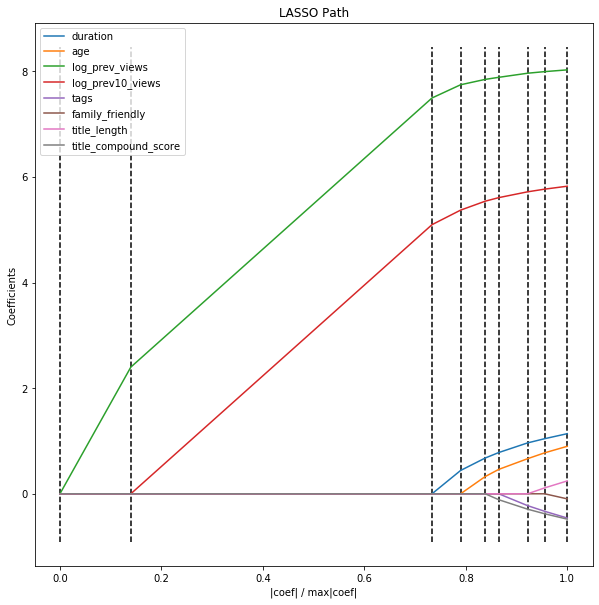

In [199]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10, 10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

### Ridge

Ridge helps identify collinearity of features and can smooth out results

In [835]:
# Instantiate Ridge model
my_grid_search = GridSearchCV(Ridge(),
                              param_grid,
                              cv=kf,
                              n_jobs=-1,
                              scoring='r2')

In [593]:
my_grid_search.fit(X_train_scaled, y_train)

In [594]:
ridge_gridcv_model = my_grid_search.best_estimator_

In [675]:
print('Ridge Model Alpha = {:f}'.format(ridge_gridcv_model.alpha))

Ridge Model Alpha = 32.925260


In [839]:
# Predict target values from test feature data for Ridge model
y_pred_ridge = ridge_gridcv_model.predict(X_test_scaled)

In [605]:
print('Ridge Model Coefficients')
list(zip(X.columns, ridge_gridcv_model.coef_))

Ridge Model Coefficients


[('intercept', 0.0),
 ('duration', 1.1551484324011714),
 ('age', 0.8822113362223346),
 ('log_prev_views', 7.899205246418711),
 ('log_prev10_views', 5.830402910624575),
 ('tags', -0.440935692879544),
 ('family_friendly', -0.10041494831586639),
 ('title_length', 0.2417987027971728),
 ('title_compound_score', -0.4808152400521929)]

In [836]:
print('Ridge model on in-sample data R^2: {:f}'.format(
    ridge_gridcv_model.score(X_train_scaled, y_train)))
print('Ridge model on out-of-sample data R^2: {:f}'.format(
    ridge_gridcv_model.score(X_test_scaled, y_test)))

Ridge model on in-sample data R^2: 0.679868
Ridge model on out-of-sample data R^2: 0.647536


In [599]:
# Undo box cox transformation
ridge_test_pred = undo_boxcox(y_test, y_pred_ridge)

# Calculate MAE and RMSE
mae_ridge, rmse_ridge = calc_mae_rmse(ridge_test_pred)

Mean Absolute Error
189772.54937569876
Root Mean Squared Error
379917.4960422017


In [837]:
resid_ridge = y_test - y_pred_ridge  # Calculate residuals for Ridge model

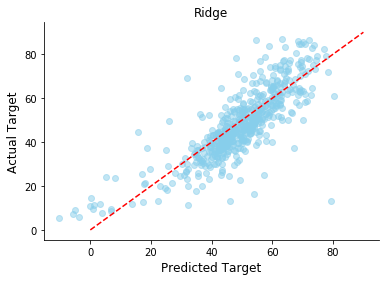

In [840]:
# Plot the predicted values vs the actual target values
plt.scatter(y_pred_ridge, y_test, color='skyblue', alpha=0.5)
plt.plot([0, 90], [0, 90], '--', c='red')
sns.despine()
plt.ylabel('Actual Target', size=12)
plt.xlabel('Predicted Target', size=12)
plt.title('Ridge')
plt.savefig('img/ridge_ycompare_bc.png')

In [841]:
# Plot residuals

# sns.distplot(resid_ridge)
# plt.title('Residuals (Linear Regression)');

### Elastic Net

Elastic net combines the cost functions of a Ridge and LASSO model. Using cross-validation, the model is optimized to the best alpha value and the best l1_ratio(the weights given to LASSO vs Ridge) to minimize the cost function

In [842]:
# Instantiate and train Elastic Net model
param_grid = {
    'alpha': 10**np.linspace(-3, 3, 600),
    'l1_ratio': np.linspace(0.1, 1, num=10)
}
elas_model = GridSearchCV(ElasticNet(),
                          param_grid,
                          cv=kf,
                          n_jobs=-1,
                          scoring='r2')
elas_model.fit(X_train_scaled, y_train)

In [843]:
elas_model_cv = elas_model.best_estimator_

In [847]:
# Predict target values based on test feature data for Elastic Net Model
y_pred_elas = elas_model_cv.predict(X_test_scaled)

In [846]:
# Look at optimized model parameters
print('l1 ratio = ', elas_model_cv.l1_ratio)  # l1 ratio
print('alpha = {:f}'.format(elas_model_cv.alpha))  # alpha

l1 ratio =  0.1
alpha = 0.026447


In [851]:
print('Elastic Net Model Coefficients')
list(zip(X.columns, elas_model_cv.coef_))

Elastic Net Model Coefficients


[('intercept', 0.0),
 ('duration', 1.1621271495262626),
 ('age', 0.8689418710800776),
 ('log_prev_views', 7.825843020405036),
 ('log_prev10_views', 5.828433061444406),
 ('tags', -0.4275005948630098),
 ('family_friendly', -0.10061018456839087),
 ('title_length', 0.23734869217012747),
 ('title_compound_score', -0.4787547527294937)]

In [848]:
# Evaluate model performance
print('Elastic Net model on in-sample data R^2: {:f}'.format(
    elas_model_cv.score(X_train_scaled, y_train)))
print('Elastic Net model on out-of-sample data R^2: {:f}'.format(
    elas_model_cv.score(X_test_scaled, y_test)))

Elastic Net model on in-sample data R^2: 0.679780
Elastic Net model on out-of-sample data R^2: 0.648161


In [850]:
# Calculate error metrics

# Undo box cox transformation
elas_test_pred = undo_boxcox(y_test, y_pred_elas)

# Calculate MAE and RMSE
mae_ridge, rmse_ridge = calc_mae_rmse(elas_test_pred)

Mean Absolute Error
189836.07631061293
Root Mean Squared Error
380289.0470278494


# Summary

After the initial feature selection and transformations, 